In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import io

In [2]:
df = pd.read_csv('../dataset/XSS2.csv', encoding='utf-8-sig')
df.head()

,No,Sentence,Label
0,0,"boom of the 1980s: rise of <a href=""/wiki/expe...",0
1,1,/vulnerabilities/fi/,0
2,2,"<div draggable=""true"" contenteditable>drag me<...",1
3,3,"<template onmouseleave=""alert(1)"">test</template>",1
4,4,<style>@keyframes x{from {left:0;}to {left: 10...,1


In [3]:
df['Label'].value_counts()

Label
1    7490
0    3703
Name: count, dtype: int64

In [4]:
# Prepocess
data = df['Sentence'].values
label = df['Label'].values

trainX, testX, trainY, testY = train_test_split(data, label, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenization and word embedding
max_sequence_length = 1000  # Maximum sequence length
max_num_words = 1000  # Maximum number of unique words

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(trainX)

In [6]:
import json

# Save the tokenizer's word-to-index mapping to a JSON file
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as json_file:
    json.dump(tokenizer_json, json_file, ensure_ascii=False, indent=4)

In [7]:
trainX_sequences = tokenizer.texts_to_sequences(trainX)
testX_sequenceS = tokenizer.texts_to_sequences(testX)


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
trainX_padded = pad_sequences(trainX_sequences,max_sequence_length)
testX_padded = pad_sequences(testX_sequenceS,max_sequence_length)

In [9]:
from sklearn.preprocessing import LabelEncoder

#Encoding labels
label_encoder = LabelEncoder()

y_train =  label_encoder.fit_transform(trainY)
y_test = label_encoder.transform(testY)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# LSTM model configuration
embedding_dim = 100   # Dimensionality of the word embeddings
lstm_units = 128    # Number of LSTM units

model=tf.keras.models.Sequential([

    tf.keras.layers.Embedding(input_dim=1000, output_dim=100, input_length=1000),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')

])

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         100000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 242,081
Trainable params: 242,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print(" \n Reached 98% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [13]:
print("Shape of trainX:", trainX_padded.shape)
print("Shape of testX:", testX_padded.shape)

Shape of trainX: (8954, 1000)
Shape of testX: (2239, 1000)


In [14]:
batch_size = 128
num_epoch = 50
#model training
model_log = model.fit(trainX_padded, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=( testX_padded,  y_test)
#                        callbacks=[callbacks]
                     )

Epoch 1/50
70/70 [==============================] - 15s 161ms/step - loss: 0.2164 - accuracy: 0.9060 - val_loss: 0.0254 - val_accuracy: 0.9911
Epoch 2/50
70/70 [==============================] - 10s 150ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.0164 - val_accuracy: 0.9951
Epoch 3/50
70/70 [==============================] - 10s 144ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.0162 - val_accuracy: 0.9955
Epoch 4/50
70/70 [==============================] - 10s 145ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 5/50
70/70 [==============================] - 10s 148ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0166 - val_accuracy: 0.9964
Epoch 6/50
70/70 [==============================] - 11s 152ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0180 - val_accuracy: 0.9964
Epoch 7/50
70/70 [==============================] - 11s 150ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0183 - val_accuracy: 0.9964

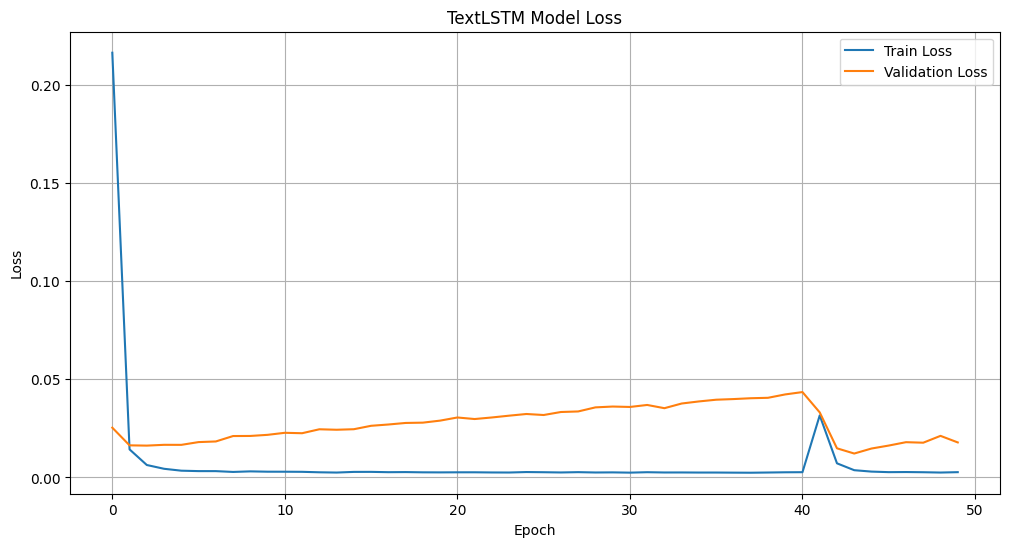

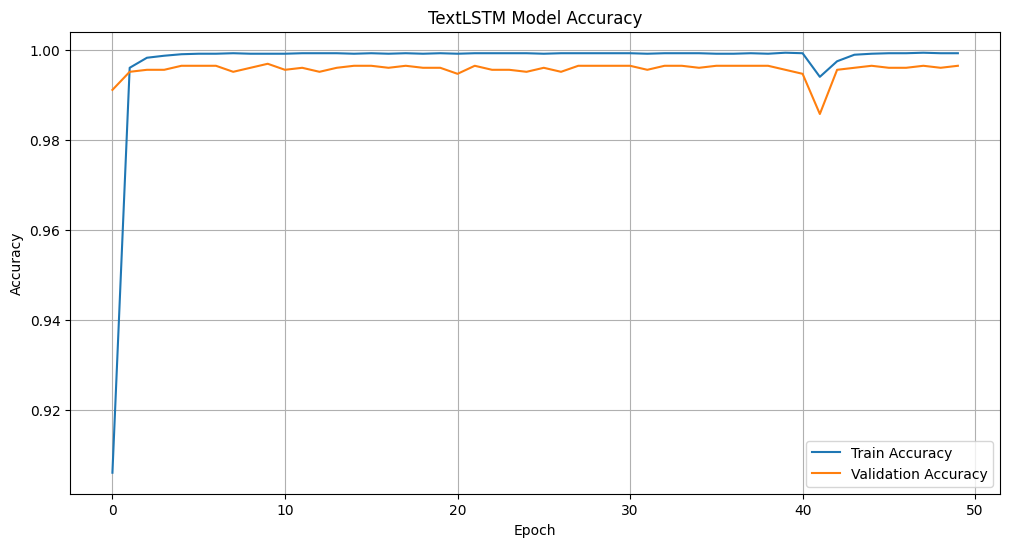

In [15]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['loss'], label='Train Loss')
plt.plot(model_log.history['val_loss'], label='Validation Loss')
plt.title('TextLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['accuracy'], label='Train Accuracy')
plt.plot(model_log.history['val_accuracy'], label='Validation Accuracy')
plt.title('TextLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [16]:
model.save("../web/models/LSTM.keras")
#loaded_model = keras.models.load_model("../web/models/LSTM.keras")
#assert np.allclose(model.predict(testX), loaded_model.predict(testX))

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Bước 1: Dự đoán nhãn
y_pred_prob = model.predict(testX_padded)  # Dự đoán xác suất nhãn
y_pred = (y_pred_prob > 0.5).astype(int)   # Chuyển đổi xác suất thành nhãn nhị phân (ngưỡng 0.5)

# Bước 2: Tính Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Bước 3: In kết quả
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


70/70 [==============================] - 3s 38ms/step
Accuracy: 0.9964269763287181
Precision: 0.997968855788761
Recall: 0.9966193373901284
F1-Score: 0.9972936400541272
